# Ingeligencja obliczeniowa
## Projekt 3: TS 1 - Podstawy Gymnasium
Olgierd Piofczyk, Kaja Dzielnicka

Zaimplementowano rozwiązywanie problemu w środowisku [`Taxi-v3` z Gymnasium](https://gymnasium.farama.org/environments/toy_text/taxi/).
Agentem jest taksówka, mająca za zadanie przewożenie pasażerów między wyznaczonymi miejscami na siatce 5x5. Agent może wykonać jedną z sześciu możliwych akcji: ruch na północ, południe, wschód, zachód, podjęcie pasażera oraz wysadzenie pasażera.

## Algorytm Q-learning
Zastosowano uczenie ze wzmocnieniem, konkretnie algorytmu [Q-learning](https://en.wikipedia.org/wiki/Q-learning).
W metodzie Q-learning kluczową role odgrywa tablica dyktująca agenta. Na początku inicjalizuje się ją bliskimi zera wartościami. Następnie agent w każdym kroku wybiera najlepszą wartość z tablicy Q i realizuje odpowiadający jej ruch. Do tego istnieje pewna szansa na zignorowanie tablicy i wykonanie losowego legalnego ruchu (tzw. eksploracja). Szansa na losową eksplorację maleje z kolejnymi epokami. Agent po wykonaniu ruchu dostaje ze środowiska nagrodę i na jej podstawie aktualizuje zawartość tablicy Q.

Algorytm Q-learning nie wymaga modelowania problemu, opiera się jedynie na doświadczeniach agenta.

## Implementacja
Implementacja skryptu rozpoczyna się od inicjalizacji środowiska, tabeli Q oraz parametrów algorytmu (np. współczynnik uczenia równy 0.9, współczynnik dyskontowania równy 0.9, szansę eksploracji początkowo równą 0.02 i malejącą w każdym kroku). W trakcie każdego epizodu agent podejmuje akcje bazując na obecnej polityce, następnie obserwuje nagrodę i nowy stan, po czym aktualizuje tabelę Q zgodnie z równaniem
$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$
Po zakończeniu epizodu wartość epsilon jest zmniejszana, co z czasem skutkuje mniejszą eksploracją i większą eksploatacją nauczonej polityki.

In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(episodes, is_training=True, render=False, learning_rate_a=0.9, discount_factor_g=0.9, epsilon=0.02, epsilon_decay_rate=0.001, plotcolor='b'):
    env = gym.make('Taxi-v3', render_mode='human' if render else None)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        f = open('taxi.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state, reward, terminated, truncated, _ = env.step(action)

            if is_training:
                q[state,action] += learning_rate_a * (reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action])
            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        rewards_per_episode[i] = reward

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards, color=plotcolor)
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards')
    # plt.savefig('taxi.png')

    if is_training:
        f = open("taxi.pkl","wb")
        pickle.dump(q, f)
        f.close()

## Eksperymenty z AI
Ze wspomnianymi parametrami agent osiąga optymalne zachowanie po ok. 200 iteracjach, co pokazuje poniższy wykres nagrody w zależności od iteracji.

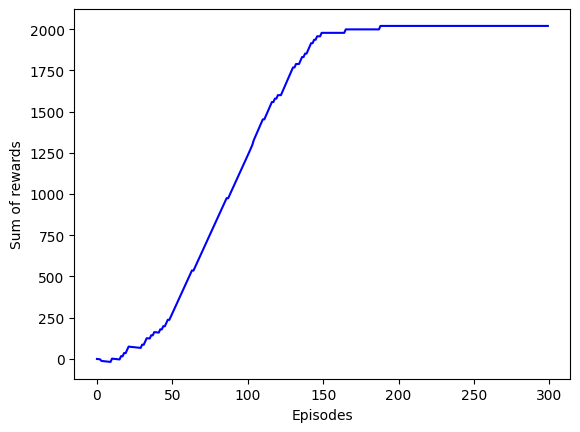

In [29]:
run(300, is_training=True, render=False)

Wartość współczynnika dyskontowego nie ma znacznego wpływu na proces uczenia. Największe znaczenie zdaje się mieć szansa na eksplorację oraz szybkość spadku tej szansy.

### Eksperyment 1: Wpływ współczynnika uczenia (learning_rate_a)
W eksperymencie zmieniono wartość współczynnika uczenia na 0.1, 0.5, 0.9.

**Oczekiwane rezultaty**:
Wyższe wartości współczynnika uczenia mogą przyspieszyć uczenie, ale mogą też prowadzić do niestabilności w wynikach. Niskie wartości będą stabilniejsze, ale mogą wymagać więcej epizodów do osiągnięcia optymalnych wyników.

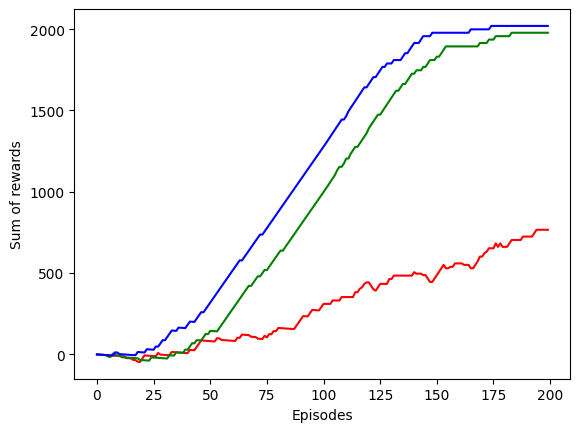

In [30]:
run(200, is_training=True, render=False, learning_rate_a=0.1, plotcolor='r')
run(200, is_training=True, render=False, learning_rate_a=0.5, plotcolor='g')
run(200, is_training=True, render=False, learning_rate_a=0.9, plotcolor='b')

### Eksperyment 2: Wpływ współczynnika dyskontującego (discount_factor_g)
W eksperymencie zmieniono wartość współczynnika dyskontującego na 0.1, 0.5, 0.9.

**Oczekiwane rezultaty**:
Wyższe wartości współczynnika skupiają uwagę agenta na długoterminowych nagrodach, potencjalnie poprawiając ostateczne wyniki, ale mogą też spowodować wolniejsze adaptacje do nagród krótkoterminowych.

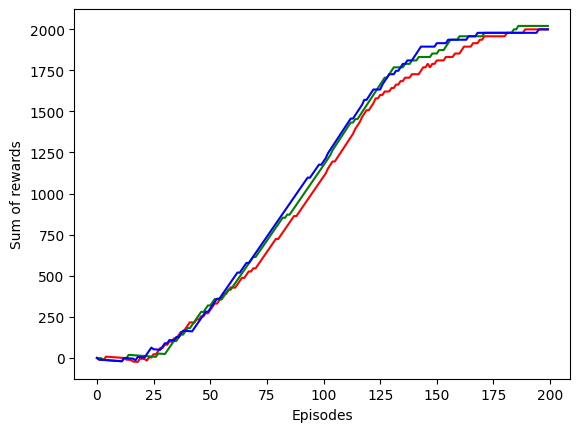

In [31]:
run(200, is_training=True, render=False, discount_factor_g=0.1, plotcolor='r')
run(200, is_training=True, render=False, discount_factor_g=0.5, plotcolor='g')
run(200, is_training=True, render=False, discount_factor_g=0.9, plotcolor='b')

### Eksperyment 3: Wpływ parametru eksploracji (epsilon i epsilon_decay_rate)

**Oczekiwane rezultaty**:
Wysoki początkowy epsilon z szybkim tempem zaniku może pozwolić na szybkie przejście od eksploracji do eksploatacji, co może być korzystne w stabilnym środowisku.

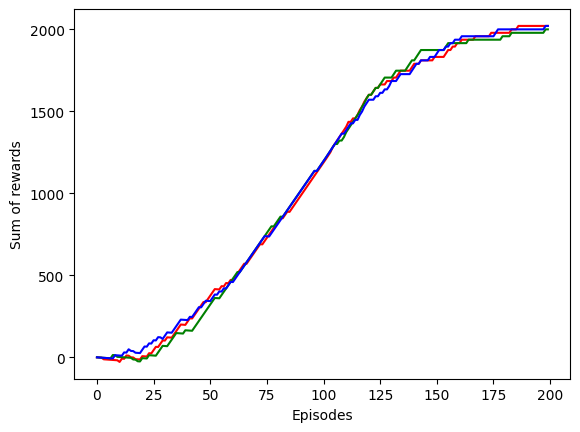

In [32]:
run(200, is_training=True, render=False, epsilon=0.1, epsilon_decay_rate=0.01, plotcolor='r')
run(200, is_training=True, render=False, epsilon=0.2, epsilon_decay_rate=0.005, plotcolor='g')
run(200, is_training=True, render=False, epsilon=0.05, epsilon_decay_rate=0.015, plotcolor='b')